# RMDS Workshop 3 Code

The code below is the code used to walkthrough a basic Customer Lifetime Value modeling process as shown by the slides. At the bottom, there is an additional challenge presented to you to model another transaction dataset.

In [1]:
# Loading Data
import lifetimes
from lifetimes.datasets import load_transaction_data
transaction_data = load_transaction_data()

print(transaction_data.head())

                  date  id
0  2014-03-08 00:00:00   0
1  2014-05-21 00:00:00   1
2  2014-03-14 00:00:00   2
3  2014-04-09 00:00:00   2
4  2014-05-21 00:00:00   2


In [2]:
#Creating an RFM Matrix
from lifetimes.utils import summary_data_from_transaction_data

rfm_matrix = summary_data_from_transaction_data(transaction_data, 'id', 'date')
print(rfm_matrix)

      frequency  recency      T
id                             
0           0.0      0.0  298.0
1           0.0      0.0  224.0
2           6.0    142.0  292.0
3           0.0      0.0  147.0
4           2.0      9.0  183.0
...         ...      ...    ...
4995        0.0      0.0  336.0
4996        4.0     80.0  293.0
4997        0.0      0.0  304.0
4998        0.0      0.0  306.0
4999        0.0      0.0  165.0

[5000 rows x 3 columns]


In [3]:
# Switch Datasets to Include Monetary Value
from lifetimes.datasets import load_cdnow_summary_data_with_monetary_value
rfm_matrix = load_cdnow_summary_data_with_monetary_value()

print(rfm_matrix.head())

             frequency  recency      T  monetary_value
customer_id                                           
1                    2    30.43  38.86           22.35
2                    1     1.71  38.86           11.77
3                    0     0.00  38.86            0.00
4                    0     0.00  38.86            0.00
5                    0     0.00  38.86            0.00


In [4]:
# Fit BG/NBD Model
from lifetimes import BetaGeoFitter
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(rfm_matrix['frequency'], rfm_matrix['recency'], rfm_matrix['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 2357 subjects, a: 0.79, alpha: 4.41, b: 2.43, r: 0.24>


In [5]:
print(bgf.summary)

           coef  se(coef)  lower 95% bound  upper 95% bound
r      0.242593  0.012557         0.217981         0.267205
alpha  4.413532  0.378221         3.672218         5.154846
a      0.792886  0.185719         0.428877         1.156895
b      2.425752  0.705345         1.043276         3.808229


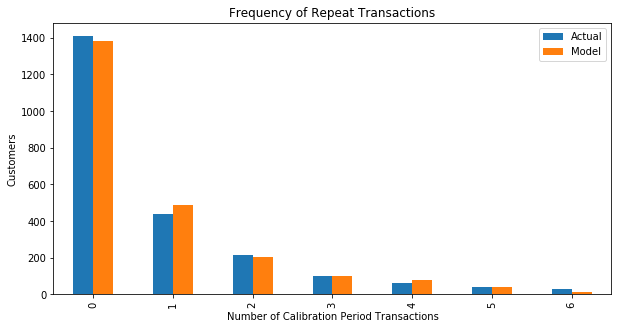

In [7]:
# Assess Model Fit

from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf, figsize = (10, 5))

In [8]:
# Predict Number of Transaction for a Single Customer

t = 10 #predict purchases in 10 periods
individual = rfm_matrix.iloc[20]

print(individual)

frequency          2.00
recency           14.57
T                 38.71
monetary_value    32.30
Name: 21, dtype: float64


In [9]:
# Predict Number of Purchases in Next 10 Time Periods

prediction = bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])
print(prediction)

0.20055896982544846


In [10]:
# Checking if Rate and Monetary Value are Independent
returning_customers_summary = rfm_matrix[rfm_matrix['frequency']>0]
returning_customers_summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.113884
frequency,0.113884,1.000000


In [13]:
# Fitting Monetary Value Model
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 946 subjects, p: 6.25, q: 3.74, v: 15.45>


In [12]:
# Predicting Customer Lifetime Value
print(ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    rfm_matrix['frequency'],
    rfm_matrix['recency'],
    rfm_matrix['T'],
    rfm_matrix['monetary_value'],
    time=12, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
).head(10))

customer_id
1      140.096218
2       18.943466
3       38.180575
4       38.180575
5       38.180575
6     1003.868285
7       28.109681
8       38.180575
9      167.418224
10      38.180575
Name: clv, dtype: float64


# Additional Challenge

Using the transaction dataset found [here](https://archive.ics.uci.edu/ml/datasets/Online+Retail+II), fit a Customer Lifetime Value model using the steps we established and report results in the fashion most interesting to you. Note, some data cleaning will be necessary in order to get the dataset into a workable format for LTV analysis. That's part of the fun / learning too. If you're not confident in your data cleaning ability, I have provided a file 'clean_invoice_data.csv' which allows you to start modeling immediately.

In [48]:
import pandas as pd

invoice_data = pd.read_csv("clean_invoice_data.csv")
invoice_data = invoice_data.iloc[:32742,]

print(invoice_data)

       CustomerId        Date   Amount
0         12347.0  2010-10-31   611.53
1         12347.0  2010-12-07   711.79
2         12347.0  2011-01-26   475.39
3         12347.0  2011-04-07   636.25
4         12347.0  2011-06-09   382.52
...           ...         ...      ...
32737     18287.0  2010-09-21   892.60
32738     18287.0  2010-11-22   381.50
32739     18287.0  2011-05-22   765.28
32740     18287.0  2011-10-12  1001.32
32741     18287.0  2011-10-28    70.68

[32742 rows x 3 columns]


In [49]:
#Creating an RFM Matrix
from lifetimes.utils import summary_data_from_transaction_data

rfm_matrix = summary_data_from_transaction_data(invoice_data, 'CustomerId', 'Date', 'Amount')
print(rfm_matrix)

            frequency  recency      T  monetary_value
CustomerId                                           
12347.0           7.0    402.0  404.0      615.714286
12348.0           4.0    363.0  438.0      449.310000
12349.0           3.0    571.0  589.0     1120.056667
12350.0           0.0      0.0  310.0        0.000000
12351.0           0.0      0.0  375.0        0.000000
...               ...      ...    ...             ...
18283.0          18.0    655.0  658.0      142.666667
18284.0           0.0      0.0  431.0        0.000000
18285.0           0.0      0.0  660.0        0.000000
18286.0           1.0    247.0  723.0      833.480000
18287.0           5.0    529.0  571.0      622.276000

[5837 rows x 4 columns]


In [50]:
# Fit BG/NBD Model
from lifetimes import BetaGeoFitter
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(rfm_matrix['frequency'], rfm_matrix['recency'], rfm_matrix['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 5837 subjects, a: 0.10, alpha: 64.62, b: 2.31, r: 0.67>


In [51]:
print(bgf.summary)

            coef  se(coef)  lower 95% bound  upper 95% bound
r       0.673262  0.016150         0.641607         0.704917
alpha  64.616519  1.979044        60.737593        68.495446
a       0.104430  0.015057         0.074918         0.133941
b       2.306403  0.511682         1.303505         3.309300


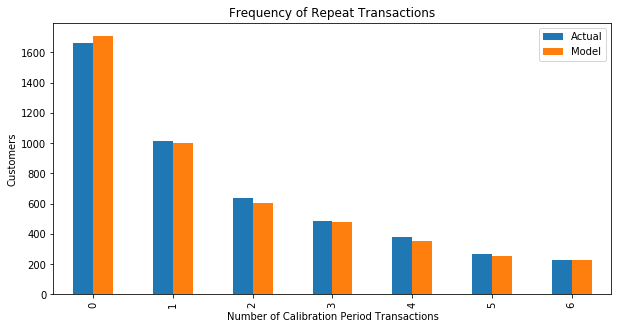

In [52]:
# Assess Model Fit

from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf, figsize = (10, 5))

In [53]:
# Predict Number of Transaction for a Single Customer

t = 10 #predict purchases in 10 periods
individual = rfm_matrix.iloc[25]

print(individual)

frequency           2.00
recency           225.00
T                 296.00
monetary_value    449.41
Name: 12372.0, dtype: float64


In [54]:
# Predict Number of Purchases in Next 10 Time Periods

prediction = bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])
print(prediction)

0.07006500345519666


In [55]:
# Checking if Rate and Monetary Value are Independent
returning_customers_summary = rfm_matrix[rfm_matrix['frequency']>0]
returning_customers_summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.176287
frequency,0.176287,1.000000


In [56]:
# Fitting Monetary Value Model
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 4177 subjects, p: 2.14, q: 3.63, v: 486.51>


In [57]:
# Predicting Customer Lifetime Value
print(ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    rfm_matrix['frequency'],
    rfm_matrix['recency'],
    rfm_matrix['T'],
    rfm_matrix['monetary_value'],
    time=12, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
).head(10))

CustomerId
12347.0    3088.220717
12348.0    1280.967615
12349.0    1645.849300
12350.0     233.680691
12351.0     199.826514
12352.0    1470.750253
12353.0     269.489563
12354.0     293.411900
12355.0     341.280976
12356.0    3563.139226
Name: clv, dtype: float64
